### Imports

In [1]:
#@title [RUN] Import python modules

import os
import sys
import time
import random
import numpy as np

from scipy.stats import ortho_group

import torch
import torch.nn.functional as F
from torch.nn import Linear, ReLU, BatchNorm1d, Module, Sequential, Sigmoid

import torch_geometric
from torch_geometric.data import Data
from torch_geometric.data import Batch
from torch_geometric.datasets import QM9
import torch_geometric.transforms as T
from torch_geometric.utils import remove_self_loops, to_dense_adj, dense_to_sparse
from torch_geometric.loader import DataLoader
from torch_geometric.nn import MessagePassing, global_mean_pool
from torch_geometric.datasets import QM9
from torch_scatter import scatter

import rdkit.Chem as Chem
from rdkit.Geometry.rdGeometry import Point3D
from rdkit.Chem import QED, Crippen, rdMolDescriptors, rdmolops
from rdkit.Chem.Draw import IPythonConsole

import py3Dmol
from rdkit.Chem import AllChem

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


from IPython.display import HTML

print("All imports succeeded.")
print("Python version {}".format(sys.version))
print("PyTorch version {}".format(torch.__version__))
print("PyG version {}".format(torch_geometric.__version__))

All imports succeeded.
Python version 3.9.0 (v3.9.0:9cf6752276, Oct  5 2020, 11:29:23) 
[Clang 6.0 (clang-600.0.57)]
PyTorch version 1.13.1
PyG version 2.2.0


In [2]:
#@title [RUN] Set random seed for deterministic results

def seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed(0)
print("All seeds set.")

All seeds set.


In [3]:
class SetTarget:
    """
    This transform modifies the labels vector per data sample to only keep
    the label for a specific target (there are 19 targets in QM9).

    Note: for this practical, we have hardcoded the target to be target #0,
    i.e. the electric dipole moment of a drug-like molecule.
    (https://en.wikipedia.org/wiki/Electric_dipole_moment)
    """
    def __call__(self, data):
        target = 0 # we hardcoded choice of target
        data.y = data.y[:, target]
        return data


class CompleteGraph:
    """
    This transform adds all pairwise edges into the edge index per data sample,
    then removes self loops, i.e. it builds a fully connected or complete graph
    """
    def __call__(self, data):
        device = data.edge_index.device

        row = torch.arange(data.num_nodes, dtype=torch.long, device=device)
        col = torch.arange(data.num_nodes, dtype=torch.long, device=device)

        row = row.view(-1, 1).repeat(1, data.num_nodes).view(-1)
        col = col.repeat(data.num_nodes)
        edge_index = torch.stack([row, col], dim=0)

        edge_attr = None
        if data.edge_attr is not None:
            idx = data.edge_index[0] * data.num_nodes + data.edge_index[1]
            size = list(data.edge_attr.size())
            size[0] = data.num_nodes * data.num_nodes
            edge_attr = data.edge_attr.new_zeros(size)
            edge_attr[idx] = data.edge_attr

        edge_index, edge_attr = remove_self_loops(edge_index, edge_attr)
        data.edge_attr = edge_attr
        data.edge_index = edge_index

        return data

print("Helper functions loaded.")

Helper functions loaded.


In [4]:
#@title [RUN] Helper functions for visualization

allowable_atoms = [
    "H",
    "C",
    "N",
    "O",
    "F",
    "C",
    "Cl",
    "Br",
    "I",
    "H",
    "Unknown",
]

def to_atom(t):
    try:
        return allowable_atoms[int(t.argmax())]
    except:
        return "C"


def to_bond_index(t):
    t_s = t.squeeze()
    return [1, 2, 3, 4][
        int(
            torch.dot(
                t_s,
                torch.tensor(
                    range(t_s.size()[0]), dtype=torch.float, device=t.device
                ),
            ).item()
        )
    ]

def to_rdkit(data, device=None):
    has_pos = False
    node_list = []
    for i in range(data.x.size()[0]):
        node_list.append(to_atom(data.x[i][:5]))

    # create empty editable mol object
    mol = Chem.RWMol()
    # add atoms to mol and keep track of index
    node_to_idx = {}
    invalid_idx = set([])
    for i in range(len(node_list)):
        if node_list[i] == "Stop" or node_list[i] == "H":
            invalid_idx.add(i)
            continue
        a = Chem.Atom(node_list[i])
        molIdx = mol.AddAtom(a)
        node_to_idx[i] = molIdx

    added_bonds = set([])
    for i in range(0, data.edge_index.size()[1]):
        ix = data.edge_index[0][i].item()
        iy = data.edge_index[1][i].item()
        bond = to_bond_index(data.edge_attr[i])  # <font color='red'>TODO</font> fix this
        # bond = 1
        # add bonds between adjacent atoms

        if data.edge_attr[i].sum() == 0:
          continue

        if (
            (str((ix, iy)) in added_bonds)
            or (str((iy, ix)) in added_bonds)
            or (iy in invalid_idx or ix in invalid_idx)
        ):
            continue
        # add relevant bond type (there are many more of these)

        if bond == 0:
            continue
        elif bond == 1:
            bond_type = Chem.rdchem.BondType.SINGLE
            mol.AddBond(node_to_idx[ix], node_to_idx[iy], bond_type)
        elif bond == 2:
            bond_type = Chem.rdchem.BondType.DOUBLE
            mol.AddBond(node_to_idx[ix], node_to_idx[iy], bond_type)
        elif bond == 3:
            bond_type = Chem.rdchem.BondType.TRIPLE
            mol.AddBond(node_to_idx[ix], node_to_idx[iy], bond_type)
        elif bond == 4:
            bond_type = Chem.rdchem.BondType.SINGLE
            mol.AddBond(node_to_idx[ix], node_to_idx[iy], bond_type)

        added_bonds.add(str((ix, iy)))

    if has_pos:
        conf = Chem.Conformer(mol.GetNumAtoms())
        for i in range(data.pos.size(0)):
            if i in invalid_idx:
                continue
            p = Point3D(
                data.pos[i][0].item(),
                data.pos[i][1].item(),
                data.pos[i][2].item(),
            )
            conf.SetAtomPosition(node_to_idx[i], p)
        conf.SetId(0)
        mol.AddConformer(conf)

    # Convert RWMol to Mol object
    mol = mol.GetMol()
    mol_frags = rdmolops.GetMolFrags(mol, asMols=True, sanitizeFrags=False)
    largest_mol = max(mol_frags, default=mol, key=lambda m: m.GetNumAtoms())
    return largest_mol


def MolTo3DView(mol, size=(300, 300), style="stick", surface=False, opacity=0.5):
    """Draw molecule in 3D

    Args:
    ----
        mol: rdMol, molecule to show
        size: tuple(int, int), canvas size
        style: str, type of drawing molecule
               style can be 'line', 'stick', 'sphere', 'carton'
        surface, bool, display SAS
        opacity, float, opacity of surface, range 0.0-1.0
    Return:
    ----
        viewer: py3Dmol.view, a class for constructing embedded 3Dmol.js views in ipython notebooks.
    """
    assert style in ('line', 'stick', 'sphere', 'carton')

    mol = Chem.AddHs(mol)
    AllChem.EmbedMolecule(mol)
    AllChem.MMFFOptimizeMolecule(mol, maxIters=200)
    mblock = Chem.MolToMolBlock(mol)
    viewer = py3Dmol.view(width=size[0], height=size[1])
    viewer.addModel(mblock, 'mol')
    viewer.setStyle({style:{}})
    if surface:
        viewer.addSurface(py3Dmol.SAS, {'opacity': opacity})
    viewer.zoomTo()
    return viewer

def smi2conf(smiles):
    '''Convert SMILES to rdkit.Mol with 3D coordinates'''
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        mol = Chem.AddHs(mol)
        AllChem.EmbedMolecule(mol)
        AllChem.MMFFOptimizeMolecule(mol, maxIters=200)
        return mol
    else:
        return None

print("Helper functions added.")

Helper functions added.


In [5]:
RESULTS = {}
DF_RESULTS = pd.DataFrame(columns=["Test MAE", "Val MAE", "Epoch", "Model"])

In [6]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    path = './qm9'
    target = 0

    # Transforms which are applied during data loading:
    # (1) Fully connect the graphs, (2) Select the target/label
    transform = T.Compose([CompleteGraph(), SetTarget()])

    # Load the QM9 dataset with the transforms defined
    dataset = QM9(path, transform=transform)

    # Normalize targets per data sample to mean = 0 and std = 1.
    mean = dataset.data.y.mean(dim=0, keepdim=True)
    std = dataset.data.y.std(dim=0, keepdim=True)
    dataset.data.y = (dataset.data.y - mean) / std
    mean, std = mean[:, target].item(), std[:, target].item()

In [7]:
# Load QM9 dataset with sparse graphs (by removing the full graphs transform)
sparse_dataset = QM9(path, transform=SetTarget())

# Normalize targets per data sample to mean = 0 and std = 1.
mean = sparse_dataset.data.y.mean(dim=0, keepdim=True)
std = sparse_dataset.data.y.std(dim=0, keepdim=True)
sparse_dataset.data.y = (sparse_dataset.data.y - mean) / std
mean, std = mean[:, target].item(), std[:, target].item()

# Split datasets (3K subset)
train_dataset_sparse = sparse_dataset[:1000]

In [8]:
data = train_dataset_sparse[999]
print(data)

Data(x=[11, 11], edge_index=[2, 22], edge_attr=[22, 4], y=[1], pos=[11, 3], idx=[1], name='gdb_1026', z=[11])


In [9]:
print(f"Total number of samples: {len(dataset)}.")

# Split datasets (in case of using the full dataset)
# test_dataset = dataset[:10000]
# val_dataset = dataset[10000:20000]
# train_dataset = dataset[20000:]

# Split datasets (our 3K subset)
train_dataset = dataset[:1000]
val_dataset = dataset[1000:2000]
test_dataset = dataset[2000:3000]
print(f"Created dataset splits with {len(train_dataset)} training, {len(val_dataset)} validation, {len(test_dataset)} test samples.")

# Create dataloaders with batch size = 32
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Total number of samples: 130831.
Created dataset splits with 1000 training, 1000 validation, 1000 test samples.


Let us print all the attributes (along with their shapes) that our PyG molecular graph contains:
Data(x=[11, 11], edge_index=[2, 110], edge_attr=[110, 4], y=[1], pos=[11, 3], idx=[1], name='gdb_1026', z=[11])


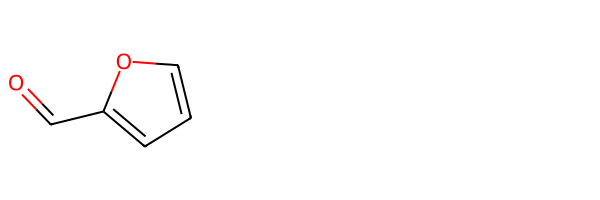

In [10]:
data = train_dataset[999] # one data sample, i.e. molecular graph
print("Let us print all the attributes (along with their shapes) that our PyG molecular graph contains:")
print(data)
Chem.Draw.MolsToGridImage([to_rdkit(data)])

In [11]:
import random
from torch_geometric.data import Data

In [12]:
#@title [RUN] Helper functions for managing experiments, training, and evaluating models.

def train(model, train_loader, optimizer, device):
    model.train()
    loss_all = 0

    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        y_pred = model(data)
        loss = F.mse_loss(y_pred, data.y)
        loss.backward()
        loss_all += loss.item() * data.num_graphs
        optimizer.step()
    return loss_all / len(train_loader.dataset)


def eval(model, loader, device):
    model.eval()
    error = 0

    for data in loader:
        data = data.to(device)
        with torch.no_grad():
            y_pred = model(data)
            # Mean Absolute Error using std (computed when preparing data)
            error += (y_pred * std - data.y * std).abs().sum().item()
    return error / len(loader.dataset)


def run_experiment(model, model_name, train_loader, val_loader, test_loader, n_epochs=100):

    print(f"Running experiment for {model_name}, training on {len(train_loader.dataset)} samples for {n_epochs} epochs.")

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    print("\nModel architecture:")
    print(model)
    total_param = 0
    for param in model.parameters():
        total_param += np.prod(list(param.data.size()))
    print(f'Total parameters: {total_param}')
    model = model.to(device)

    # Adam optimizer with LR 1e-3
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # LR scheduler which decays LR when validation metric doesn't improve
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.9, patience=5, min_lr=0.00001)

    print("\nStart training:")
    best_val_error = None
    perf_per_epoch = [] # Track Test/Val MAE vs. epoch (for plotting)
    t = time.time()
    for epoch in range(1, n_epochs+1):
        # Call LR scheduler at start of each epoch
        lr = scheduler.optimizer.param_groups[0]['lr']

        # Train model for one epoch, return avg. training loss
        loss = train(model, train_loader, optimizer, device)

        # Evaluate model on validation set
        val_error = eval(model, val_loader, device)

        if best_val_error is None or val_error <= best_val_error:
            # Evaluate model on test set if validation metric improves
            test_error = eval(model, test_loader, device)
            best_val_error = val_error

        if epoch % 10 == 0:
            # Print and track stats every 10 epochs
            print(f'Epoch: {epoch:03d}, LR: {lr:5f}, Loss: {loss:.7f}, '
                  f'Val MAE: {val_error:.7f}, Test MAE: {test_error:.7f}')

        scheduler.step(val_error)
        perf_per_epoch.append((test_error, val_error, epoch, model_name))

    t = time.time() - t
    train_time = t/60
    print(f"\nDone! Training took {train_time:.2f} mins. Best validation MAE: {best_val_error:.7f}, corresponding test MAE: {test_error:.7f}.")

    return best_val_error, test_error, train_time, perf_per_epoch

In [13]:
from src.models import MPNNModel

model = MPNNModel(num_layers=4, emb_dim=59, in_dim=11, out_dim=1)

model_name = type(model).__name__
best_val_error, test_error, train_time, perf_per_epoch = run_experiment(
    model,
    model_name, # "MPNN w/ Features and Coordinates (Equivariant Layers)",
    train_loader,
    val_loader,
    test_loader,
    n_epochs=100
)

RESULTS[model_name] = (best_val_error, test_error, train_time)
df_temp = pd.DataFrame(perf_per_epoch, columns=["Test MAE", "Val MAE", "Epoch", "Model"])
DF_RESULTS = DF_RESULTS.append(df_temp, ignore_index=True)

Running experiment for MPNNModel, training on 1000 samples for 100 epochs.

Model architecture:
MPNNModel(
  (emb_in): Embedding(11, 59)
  (convs): ModuleList(
    (0): MPNNLayer(emb_dim=59, aggr=sum)
    (1): MPNNLayer(emb_dim=59, aggr=sum)
    (2): MPNNLayer(emb_dim=59, aggr=sum)
    (3): MPNNLayer(emb_dim=59, aggr=sum)
  )
  (pred): Sequential(
    (0): Linear(in_features=59, out_features=59, bias=True)
    (1): ReLU()
    (2): Linear(in_features=59, out_features=1, bias=True)
  )
)
Total parameters: 90625

Start training:



KeyboardInterrupt

